In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score
from scipy.sparse.linalg import svds

### Loading Data

In [8]:
DATA_DIR = "data/ml-100k/"

In [10]:
ratings = pd.read_csv("ml-100k/u.data",
                      sep="\t",
                      names=["user_id","movie_id","rating","timestamp"])

print("Ratings shape:", ratings.shape)
print(ratings.head())

Ratings shape: (100000, 4)
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596


In [11]:
movies = pd.read_csv(
    "ml-100k/u.item",
    sep="|",
    encoding="latin-1",
    names=["movie_id", "title", "release_date", "video_release_date", "IMDb_URL"] +
          [f"genre_{i}" for i in range(19)]
)

print("Movies shape:", movies.shape)
print(movies.head())

Movies shape: (1682, 24)
   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  genre_0  genre_1  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0        0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0        1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0        0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0        1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0        0   

   genre_2  genre_3  genre_4  ...  genre_9  genre_10  genre_11  genre_12  \
0        0        1        1  ...        0         

## Merge Ratings with Movies

In [12]:
df = pd.merge(ratings, movies[["movie_id", "title"]], on="movie_id")
print("Merged data shape:", df.shape)
print(df.head())

Merged data shape: (100000, 5)
   user_id  movie_id  rating  timestamp                       title
0      196       242       3  881250949                Kolya (1996)
1      186       302       3  891717742    L.A. Confidential (1997)
2       22       377       1  878887116         Heavyweights (1994)
3      244        51       2  880606923  Legends of the Fall (1994)
4      166       346       1  886397596         Jackie Brown (1997)


## Exploratory Data Analysis

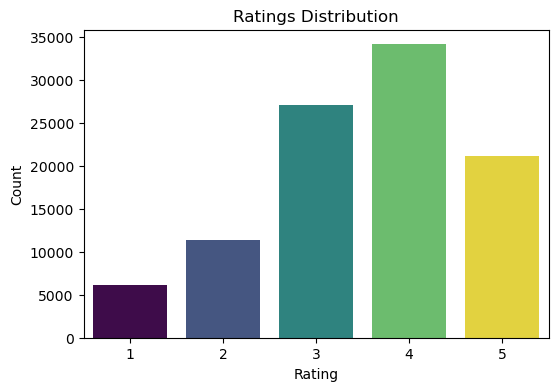

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x="rating", hue="rating", data=df, palette="viridis", legend=False)
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

People mostly give 4 star ratings


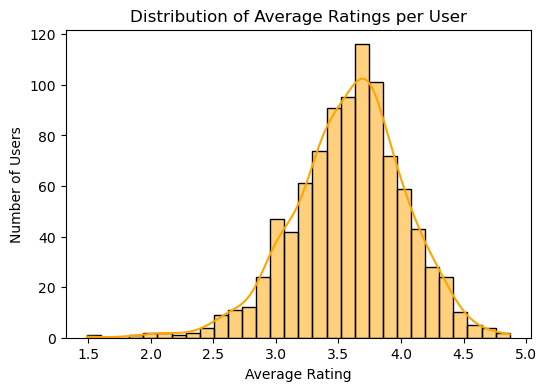

In [14]:
avg_ratings_per_user = df.groupby("user_id")["rating"].mean()

plt.figure(figsize=(6,4))
sns.histplot(avg_ratings_per_user, bins=30, kde=True, color="orange")
plt.title("Distribution of Average Ratings per User")
plt.xlabel("Average Rating")
plt.ylabel("Number of Users")
plt.show()

In [15]:
min_ratings = 50

# Group by movie and calculate mean rating + count of ratings
movie_stats = df.groupby("title")["rating"].agg(["mean", "count"])

# Filter only movies with enough ratings
popular_movies = movie_stats.query("count >= @min_ratings")

# Sort by average rating
top_rated = popular_movies.sort_values("mean", ascending=False).head(15)


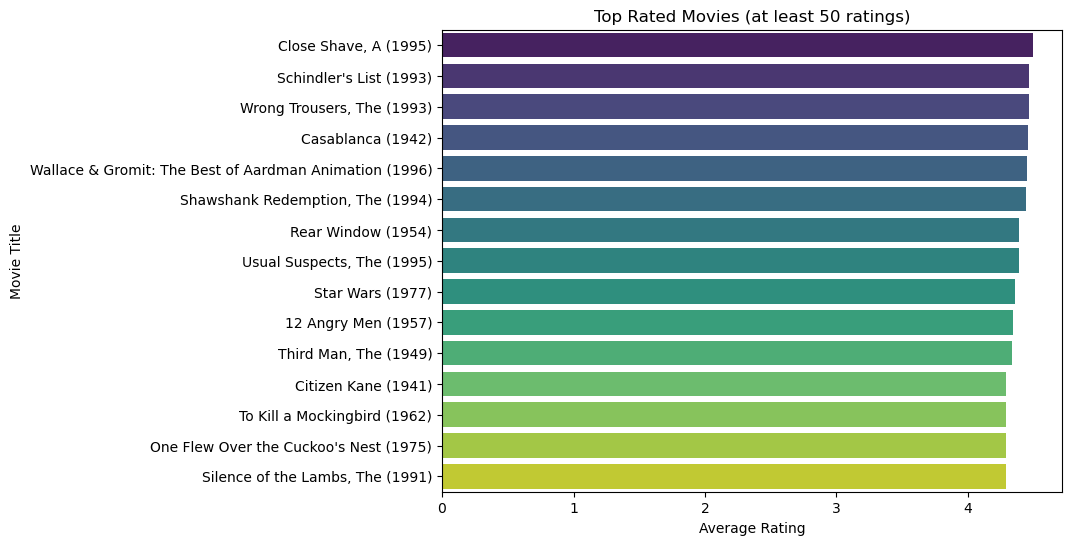

In [16]:
plt.figure(figsize=(8,6))
sns.barplot(
    x=top_rated["mean"],
    y=top_rated.index,
    hue=top_rated.index,      # assign palette to the y variable
    palette="viridis",
    legend=False
)
plt.title(f"Top Rated Movies (at least {min_ratings} ratings)")
plt.xlabel("Average Rating")
plt.ylabel("Movie Title")
plt.show()

We filtered by movies with a minimum number of ratings ≥50, so we got better insights and avoided the movies which had total ratings below 50

## Data Cleaning

In [17]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 user_id      0
movie_id     0
rating       0
timestamp    0
title        0
dtype: int64


No missing values


In [18]:
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Dropped {before - after} duplicates.")

Dropped 0 duplicates.


In [19]:
print(df.describe())

            user_id       movie_id         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e+08
50%       447.00000     322.000000       4.000000  8.828269e+08
75%       682.00000     631.000000       4.000000  8.882600e+08
max       943.00000    1682.000000       5.000000  8.932866e+08


### Normalize ratings

center per user so we remove bias like “some users always give 5”

In [20]:
# Center ratings by each user's mean
ratings["rating_norm"] = ratings.groupby("user_id")["rating"].transform(lambda x: x - x.mean())

print("Normalized ratings sample:")
print(ratings.head())

Normalized ratings sample:
   user_id  movie_id  rating  timestamp  rating_norm
0      196       242       3  881250949    -0.615385
1      186       302       3  891717742    -0.413043
2       22       377       1  878887116    -2.351562
3      244        51       2  880606923    -1.651261
4      166       346       1  886397596    -2.550000


## Train/Test Split

In [21]:
train, test = train_test_split(
        ratings,
        test_size=0.2,
        stratify=ratings["user_id"],
        random_state=42
    )

In [22]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (80000, 5)
Test shape: (20000, 5)


### User-Item Matrix

In [23]:
def build_user_item_matrix(df):
    return df.pivot_table(index="user_id", columns="movie_id", values="rating")

In [24]:
train_matrix = build_user_item_matrix(train)
test_matrix = build_user_item_matrix(test)

In [25]:
print("Train Matrix shape:", train_matrix.shape)
print("Test Matrix shape:", test_matrix.shape)

Train Matrix shape: (943, 1656)
Test Matrix shape: (943, 1408)


In [26]:
def sparsity(matrix):
    return 1.0 - (np.count_nonzero(matrix) / float(matrix.size))

print(f"Train sparsity: {sparsity(train_matrix)*100:.2f}%")
print(f"Test sparsity: {sparsity(test_matrix)*100:.2f}%")

Train sparsity: 0.00%
Test sparsity: 0.00%


### User-User Similarity

In [27]:
train_filled = train_matrix.fillna(0)

In [28]:
# Compute cosine similarity between users
user_similarity = cosine_similarity(train_filled)
user_similarity_df = pd.DataFrame(user_similarity,
                                  index=train_filled.index,
                                  columns=train_filled.index)

print("User similarity matrix shape:", user_similarity_df.shape)

User similarity matrix shape: (943, 943)


### Recommend Top-rated unseen movies for a given user

In [29]:
def movies_recommend(user_id, top_n=10):
    # Get similarity scores for this user
    sim_scores = user_similarity_df.loc[user_id]

    # Weighted ratings from similar users
    # dot(similarity, ratings) / sum(similarity)
    sim_users = train_filled.T.dot(sim_scores) / sim_scores.sum()

    # Already seen movies by this user
    seen_movies = train_matrix.loc[user_id].dropna().index

    # Exclude seen movies
    recommendations = sim_users.drop(seen_movies)

    # Top-N recommendations
    return recommendations.sort_values(ascending=False).head(top_n)

In [30]:
print("Recommendations for User 50:")
print(movies_recommend(50, top_n=5))

Recommendations for User 50:
movie_id
50     2.261966
127    1.740308
258    1.713465
181    1.677146
288    1.658508
dtype: float64


### Evaluate using Precision at K

In [31]:
def precision_at_k(test_matrix, k=10):
    precisions = []

    for user in test_matrix.index:
        # True movies the user rated in test set
        true_items = test_matrix.loc[user].dropna().index if user in test_matrix.index else []
        if len(true_items) == 0:
            continue  # skip users with no test ratings

        # Predicted top-k recommendations
        recs = movies_recommend(user, top_n=k).index

        # Hits = intersection of recommended and true items
        hits = len(set(recs).intersection(set(true_items)))

        precisions.append(hits / k)

    return np.mean(precisions)

#### Evaluate Precision at 5 and Precision at 10

In [32]:
prec_at_5 = precision_at_k(test_matrix, k=5)
prec_at_10 = precision_at_k(test_matrix, k=10)

In [33]:
print(f"Precision at 5: {prec_at_5:.4f}")
print(f"Precision at 10: {prec_at_10:.4f}")

Precision at 5: 0.3169
Precision at 10: 0.2604


Precision drops as k increases, this means:
- With more recommendations, you’re more likely to include irrelevant items.


## Item-Based Collaborative Filtering

In [34]:
# Transpose to get item-user matrix
item_filled = train_filled.T

In [35]:
# item-item cosine similarity
item_similarity = cosine_similarity(item_filled)
item_similarity_df = pd.DataFrame(item_similarity,
                                  index=item_filled.index,
                                  columns=item_filled.index)

In [36]:
def movies_recommend_item_based(user_id, top_n=10):
    # Movies the user has rated
    user_ratings = train_matrix.loc[user_id].dropna()
    # Weighted sum of similarities * ratings
    scores = pd.Series(dtype=float)

    for movie, rating in user_ratings.items():
        # Similar movies
        sim_scores = item_similarity_df[movie] * rating
        scores = scores.add(sim_scores, fill_value=0)

    # Remove already seen movies
    scores = scores.drop(user_ratings.index, errors='ignore')

    return scores.sort_values(ascending=False).head(top_n)

In [37]:
print("Item-based Recommendations for User 50:")
print(movies_recommend_item_based(50, top_n=5))

Item-based Recommendations for User 50:
movie_id
475    18.729415
50     17.442754
7      17.228101
127    17.068045
237    16.965784
dtype: float64


## Matrix Factorization with SVD

#### Create user-item rating matrix

In [38]:
R = train_matrix.fillna(0).values
user_ids = train_matrix.index
movie_ids = train_matrix.columns

#### Perform SVD

In [39]:
U, sigma, Vt = svds(R, k=50)  # k = latent factors
sigma = np.diag(sigma)

#### Predicted Ratings

In [40]:
pred_ratings = np.dot(np.dot(U, sigma), Vt)
pred_df = pd.DataFrame(pred_ratings, index=user_ids, columns=movie_ids)

### Recommend Movies (SVD based)

In [41]:
def movies_recommend_svd(user_id, top_n=10):
    # Predicted scores for user
    user_preds = pred_df.loc[user_id]

    # Remove already seen
    seen_movies = train_matrix.loc[user_id].dropna().index
    user_preds = user_preds.drop(seen_movies, errors='ignore')

    return user_preds.sort_values(ascending=False).head(top_n)

In [42]:
print("SVD-based Recommendations for User 50:")
print(movies_recommend_svd(50, top_n=5))

SVD-based Recommendations for User 50:
movie_id
475    1.338152
124    0.953972
150    0.816632
129    0.798402
14     0.728634
Name: 50, dtype: float64


### Evaluate Precision at K for Item-based & SVD

In [43]:
def precision_at_k_model(recommend_func, test_matrix, k=10):
    precisions = []
    for user in test_matrix.index:
        true_items = test_matrix.loc[user].dropna().index if user in test_matrix.index else []
        if len(true_items) == 0:
            continue

        recs = recommend_func(user, top_n=k).index
        hits = len(set(recs).intersection(set(true_items)))
        precisions.append(hits / k)
    return np.mean(precisions)

In [44]:
# Item-based evaluation
prec_item_5 = precision_at_k_model(movies_recommend_item_based, test_matrix, k=5)
prec_item_10 = precision_at_k_model(movies_recommend_item_based, test_matrix, k=10)

In [45]:
# SVD evaluation
prec_svd_5 = precision_at_k_model(movies_recommend_svd, test_matrix, k=5)
prec_svd_10 = precision_at_k_model(movies_recommend_svd, test_matrix, k=10)

In [46]:
print(f"Item-based Precision at 5: {prec_item_5:.4f}, Precision at 10: {prec_item_10:.4f}")
print(f"SVD Precision at 5: {prec_svd_5:.4f}, Precision at 10: {prec_svd_10:.4f}")

Item-based Precision at 5: 0.3601, Precision at 10: 0.3008
SVD Precision at 5: 0.3684, Precision at 10: 0.3077


## Model Comparison (Precision at K)

#### Bar chart comparing User-based, Item-based, and SVD performance.

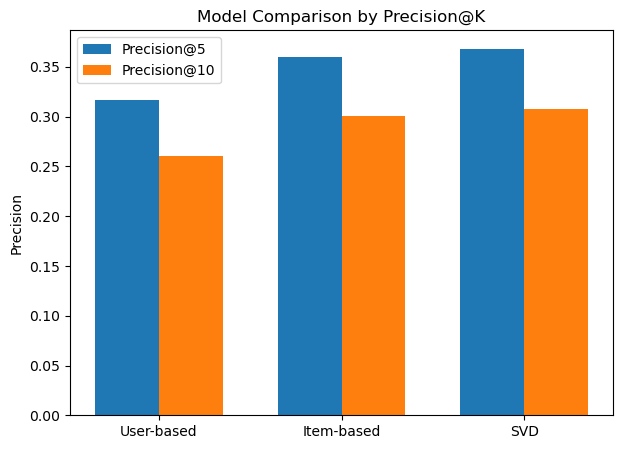

In [47]:
models = ["User-based", "Item-based", "SVD"]
prec_at5 = [prec_at_5, prec_item_5, prec_svd_5]
prec_at10 = [prec_at_10, prec_item_10, prec_svd_10]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(7,5))
plt.bar(x - width/2, prec_at5, width, label="Precision@5")
plt.bar(x + width/2, prec_at10, width, label="Precision@10")

plt.xticks(x, models)
plt.ylabel("Precision")
plt.title("Model Comparison by Precision@K")
plt.legend()
plt.show()

### General Takeaways

- **Ranking quality decreases as K increases**: Precision naturally drops when recommending more items (because more “irrelevant” movies slip in).

- **SVD > Item-based > User-based**: Confirms that in practice, matrix factorization (SVD) tends to outperform pure CF methods.

- Item-based CF is stronger than User-based CF here, which makes sense since items (movies) are usually rated by many users, but users themselves can be sparse.

## Saving Model for Deployment

In [49]:
print(ratings.columns)


Index(['user_id', 'movie_id', 'rating', 'timestamp', 'rating_norm'], dtype='object')


In [50]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

# Assuming ratings DataFrame is already cleaned and normalized
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train SVD model
svd = SVD()
svd.fit(trainset)

In [51]:
import joblib, os

os.makedirs("models", exist_ok=True)  # create folder if it doesn't exist

joblib.dump(svd, "models/svd_model.pkl")

['models/svd_model.pkl']

In [52]:
joblib.dump(item_similarity, "models/item_similarity.pkl")


['models/item_similarity.pkl']